# Extracting speech from noise



In [2]:
from IPython.display import Audio
from matplotlib import pyplot as plt 
from scipy.signal import spectrogram
import numpy as np
from scipy.io.wavfile import write
from scipy import signal
import librosa

from scipy.signal import find_peaks
from scipy.signal import butter, lfilter
from scipy.signal import filtfilt, fftconvolve, freqz, firwin2, hilbert

plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

In [3]:
noisy = 'whenisdinnerready.wav'
Audio(noisy)

# define some helper functions

In [59]:
import soundfile as sf

# Define helper functions

def get_wav_info(wav_file):
    data, rate = sf.read(wav_file)
    print('The sample rate is {}'.format(rate))
    duration = len(data)/float(rate)
    return data, rate, duration # i am returning 1st col because i forgot to export as mono


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)



# get some info on the recording

In [60]:
data, rate, duration = get_wav_info(noisy)
print("Sample rate  :", rate)
print("Signal Length:", len(data))
print("Duration     :", len(data)/rate, "seconds")

The sample rate is 48000
Sample rate  : 48000
Signal Length: 225125
Duration     : 4.690104166666667 seconds


# take a slice of the recording where there is no speech and plot it together with the whole recording

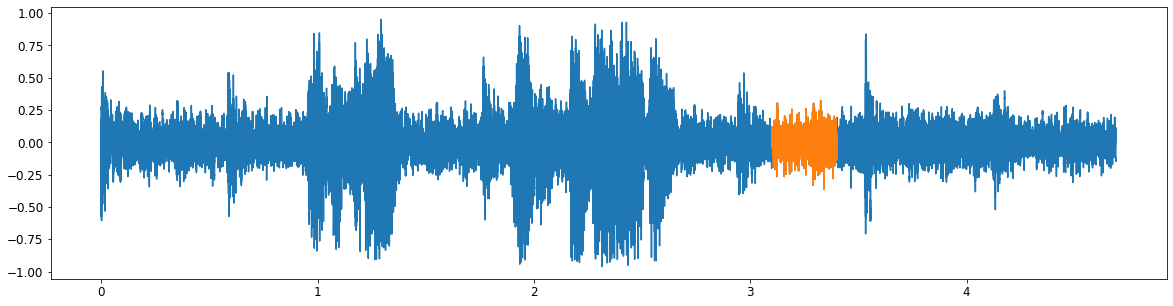

In [75]:
n = len(data)
t_ = np.arange(n)/rate

noise_clip = data[int(3.1*rate):int(3.4*rate)]
tnoise = np.arange(len(noise_clip))/rate

plt.plot(t_, data)
plt.plot(tnoise + 3.1, noise_clip)

# Get the spectral profile of the noise by doing an STFT over the full signal

In [76]:
# STFT over signal
f, t, signal_stft = signal.stft(data, rate)
dbSignal = librosa.amplitude_to_db(np.abs(signal_stft))

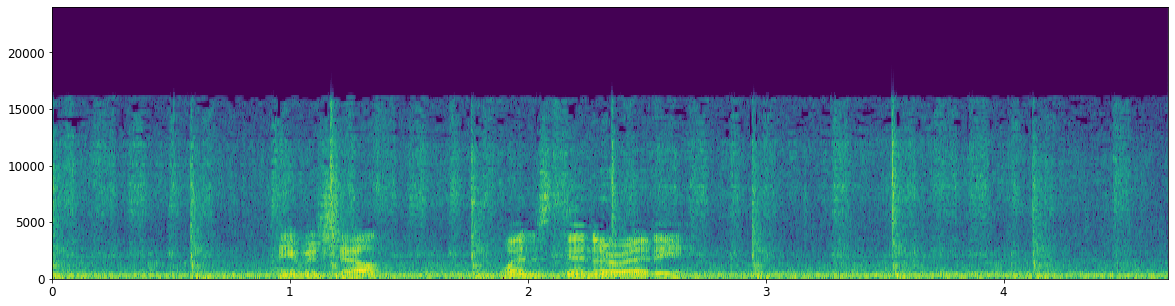

In [77]:
plt.pcolormesh(t, f, dbSignal)

# we see that in addition to the speech, there are two types of noise that need to be removed
There is a random

# Get the spectral profile of the noise by doing an STFT over the noise signal

In [78]:
f, t, noise_stft = signal.stft(noise_clip, rate)

# convert power to dB and plot the spectrogram

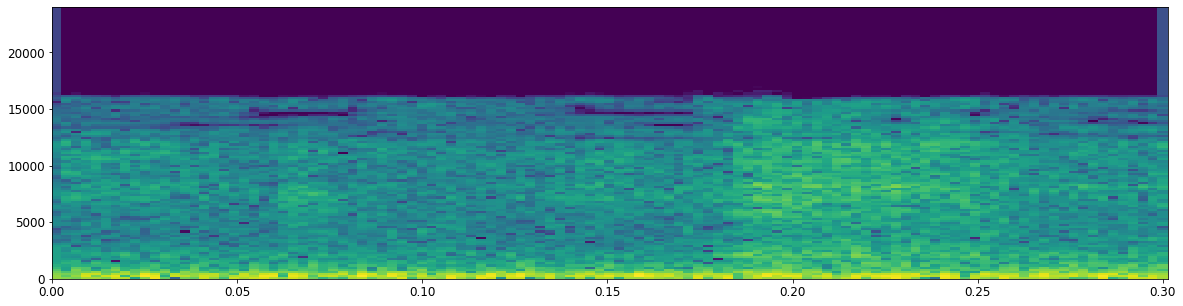

In [79]:
dbNoise = _amp_to_db(np.abs(noise_stft))
plt.pcolormesh(t, f, (dbNoise))

# record some statistics of the noise

In [80]:
# Calculate statistics over noise
n_std_thresh = 2.5

mean_freq_noise = np.mean(dbNoise, axis=1) # axis=1 is across columns, i.e., what is the mean power for each frequency (row) 
std_freq_noise = np.std(dbNoise, axis=1)
noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh

# create a smoothing filter

In [1]:
n_grad_freq=1
n_grad_time=2
# Create a smoothing filter for the mask in time and frequency
smoothing_filter = np.outer(
    np.concatenate(
        [
            np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
            np.linspace(1, 0, n_grad_freq + 2),
        ]
    )[1:-1],
    np.concatenate(
        [
            np.linspace(0, 1, n_grad_time + 1, endpoint=False),
            np.linspace(1, 0, n_grad_time + 2),
        ]
    )[1:-1],
)

smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
plt.imshow(smoothing_filter)
plt.colorbar()

NameError: name 'np' is not defined

# calculate the threshold for each frequency/time bin
repeat the row vector for however many time points there are. Stack these row repeats onto of one another

In [82]:
db_thresh = np.repeat(np.reshape(noise_thresh, (1, len(mean_freq_noise))), np.shape(dbSignal)[1],
    axis=0,
).T

# set mask to 0 if signal is below noise threshold

In [83]:
# mask if the signal is above the threshold
sig_mask = dbSignal < db_thresh

# convolve the mask with a smoothing filter

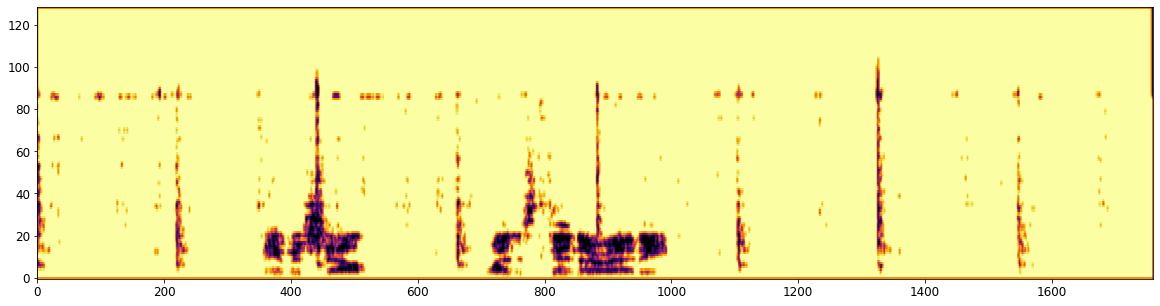

In [84]:
prop_decrease=1
sig_mask = fftconvolve(sig_mask, smoothing_filter, mode="same")
sig_mask = sig_mask * prop_decrease
plt.imshow(sig_mask, origin='lower', aspect='auto', cmap='inferno')

In [85]:
mask_gain_dB = np.min(dbSignal)
sig_stft_db_masked = (dbSignal * (1 - sig_mask) + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask)  # mask real
sig_imag_masked = np.imag(signal_stft) * (1 - sig_mask)
sig_stft_amp = (librosa.db_to_amplitude(sig_stft_db_masked) * np.sign(signal_stft)) + (1j * sig_imag_masked)

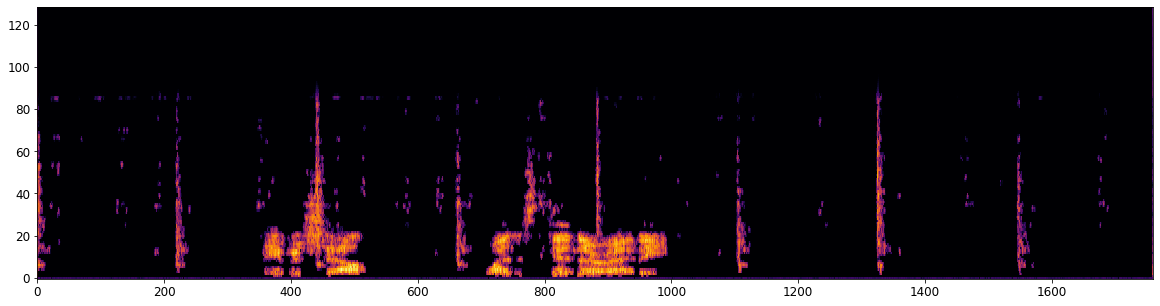

In [86]:
plt.imshow(librosa.amplitude_to_db(np.abs(sig_stft_amp)), origin='lower', aspect='auto', cmap='inferno')

In [87]:
t2, recovered_signal = signal.istft(sig_stft_amp, rate)

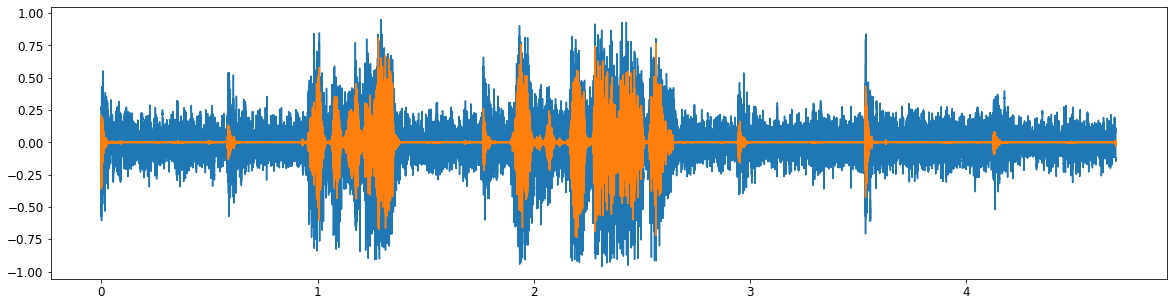

In [90]:
plt.plot(t_, data)
plt.plot(t2, recovered_signal)